## Import Library

In [1]:
# %pip install mlflow
# %pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.layers import (
    Input,
    LSTM,
    Dense,
    Dropout,
    MultiHeadAttention,
    LayerNormalization,
    GlobalAveragePooling1D,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber

import seaborn as sns


## Load Tainan City

In [3]:
# 2. Load & aggregate Tainan weekly data

# %%
df_raw = pd.read_csv("../data/3_df_merged_cleaned.csv")
df_raw["Date"] = pd.to_datetime(df_raw["Date"])

df_ks = df_raw[df_raw["City"] == "Tainan City"].set_index("Date")

agg_dict = {
    "Cases": "sum",
    "Precip": "sum",
    "Pressure": "mean",
    "Tmean": "mean",
    "Tmin": "mean",
    "Tmax": "mean",
    "Humidity": "mean",
    "Windspeed": "mean",
    "BI": "mean",
    "HI": "mean",
    "CI": "mean",
    "PopDensity_km2": "mean",
}

df_weekly = df_ks.resample("W").agg(agg_dict)
df_weekly = df_weekly.asfreq("W")
df_weekly = df_weekly.interpolate(method="time").ffill().bfill()

In [4]:
# --- Extract month and month name from the Date index ---
df_ks = df_weekly.copy()  # just for clarity
df_ks["month"] = df_ks.index.month

month_map = {
    1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun",
    7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"
}
df_ks["month_name"] = pd.Categorical(
    df_ks["month"].map(month_map),
    categories=list(month_map.values()),
    ordered=True
)


/var/folders/l_/bfn4zmvj11j3519tmtl4xcd40000gn/T/ipykernel_2265/3099634906.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


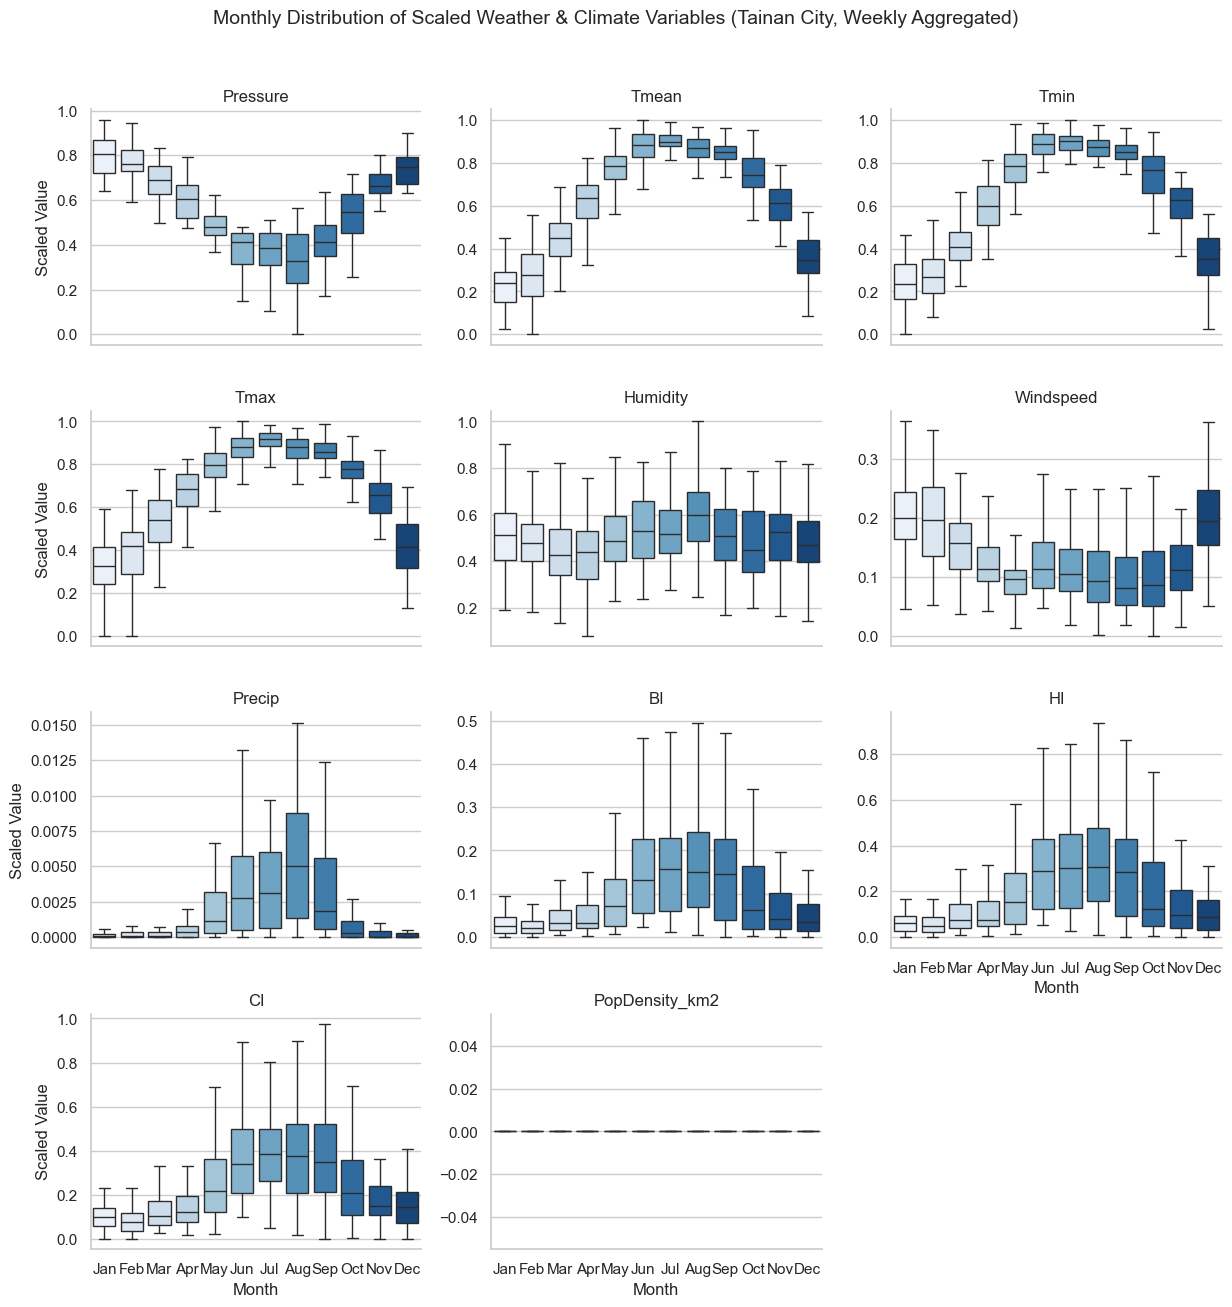

In [5]:
# --- Select climate features ---
features = [
    "Pressure", "Tmean", "Tmin", "Tmax",
    "Humidity", "Windspeed",
    "Precip", "BI", "HI", "CI", "PopDensity_km2"
]

# --- Scale all numeric variables (0–1) for comparability ---
scaler = MinMaxScaler()
df_ks_scaled = df_ks.copy()
df_ks_scaled[features] = scaler.fit_transform(df_ks[features])

# --- Melt for Seaborn FacetGrid ---
long_df = df_ks_scaled.melt(
    id_vars=["month_name"],
    value_vars=features,
    var_name="Feature",
    value_name="Value"
)

# --- Plot: Monthly boxplots for scaled climate features ---
sns.set(style="whitegrid")
g = sns.catplot(
    data=long_df,
    x="month_name", y="Value",
    col="Feature",
    kind="box",
    col_wrap=3,
    height=3.2, aspect=1.3,
    sharey=False,
    showfliers=False,
    palette="Blues"
)

g.set_axis_labels("Month", "Scaled Value")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.tick_params(axis="x", rotation=0)

g.fig.suptitle(
    "Monthly Distribution of Scaled Weather & Climate Variables (Tainan City, Weekly Aggregated)",
    y=1.02, fontsize=14
)
plt.tight_layout()
plt.show()

/var/folders/l_/bfn4zmvj11j3519tmtl4xcd40000gn/T/ipykernel_2265/3921129900.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


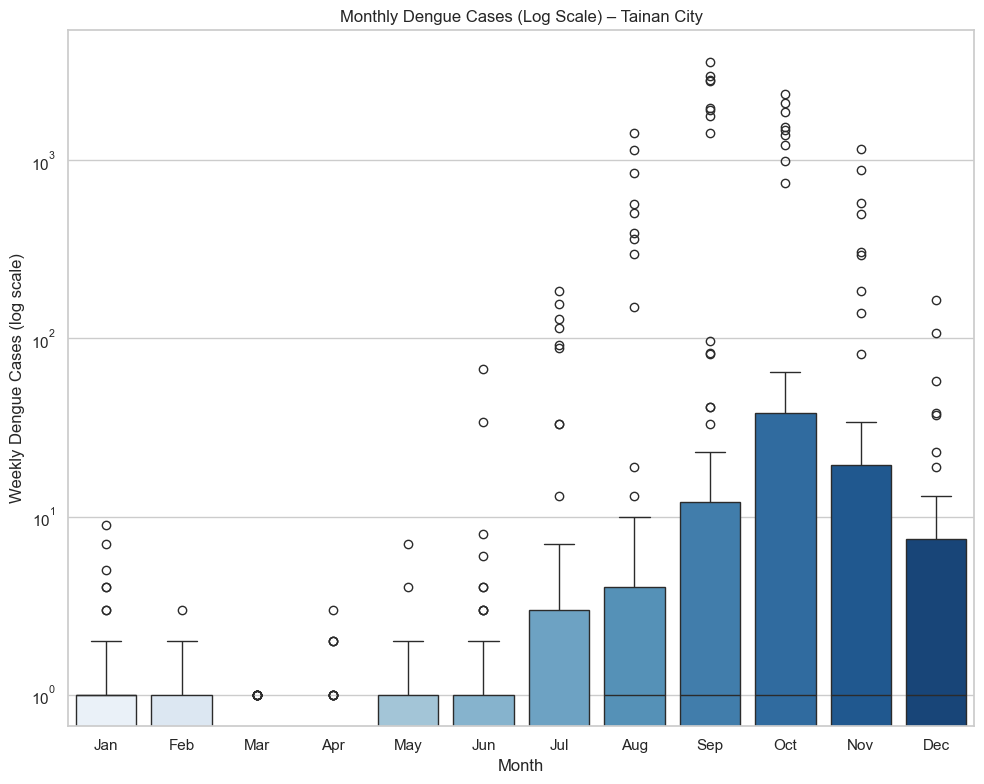

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(
    data=df_ks.reset_index(),
    x="month_name",
    y="Cases",
    ax=ax,
    palette="Blues"
)
ax.set_yscale("log")
ax.set_title("Monthly Dengue Cases (Log Scale) – Tainan City")
ax.set_xlabel("Month")
ax.set_ylabel("Weekly Dengue Cases (log scale)")
plt.tight_layout()
plt.show()

In [7]:

# ==== NEW: calendar/seasonal features ====
df_weekly["month"] = df_weekly.index.month
df_weekly["weekofyear"] = df_weekly.index.isocalendar().week.astype(int)

# cyclical encoding for month (captures Jan≈Dec)
df_weekly["month_sin"] = np.sin(2 * np.pi * df_weekly["month"] / 12)
df_weekly["month_cos"] = np.cos(2 * np.pi * df_weekly["month"] / 12)

# cyclical encoding for week-of-year (fine-grained seasonality)
df_weekly["woy_sin"] = np.sin(2 * np.pi * df_weekly["weekofyear"] / 52)
df_weekly["woy_cos"] = np.cos(2 * np.pi * df_weekly["weekofyear"] / 52)


In [8]:
# Use raw weekly cases as target
target_col = "Cases"

# Features include Cases + all other variables
feature_cols = df_weekly.columns.tolist()


df = df_weekly.copy()

# --- Train / Val / Test split by date ---
train_df = df.loc[df.index < "2022-01-01"]
test_df  = df.loc[df.index >= "2022-01-01"]

val_start = "2018-01-01"
train_inner_df = train_df.loc[train_df.index < val_start]
val_df         = train_df.loc[train_df.index >= val_start]

print("Train_inner:", train_inner_df.index.min(), "→", train_inner_df.index.max())
print("Val       :", val_df.index.min(),        "→", val_df.index.max())
print("Test      :", test_df.index.min(),      "→", test_df.index.max())

print(feature_cols)
print(df_weekly[["Cases","month_sin","month_cos","woy_sin","woy_cos"]].head(15))



Train_inner: 2010-01-03 00:00:00 → 2017-12-31 00:00:00
Val       : 2018-01-07 00:00:00 → 2021-12-26 00:00:00
Test      : 2022-01-02 00:00:00 → 2025-01-05 00:00:00
['Cases', 'Precip', 'Pressure', 'Tmean', 'Tmin', 'Tmax', 'Humidity', 'Windspeed', 'BI', 'HI', 'CI', 'PopDensity_km2', 'month', 'weekofyear', 'month_sin', 'month_cos', 'woy_sin', 'woy_cos']
            Cases  month_sin     month_cos   woy_sin       woy_cos
Date                                                              
2010-01-03    0.0   0.500000  8.660254e-01  0.120537  9.927089e-01
2010-01-10    0.0   0.500000  8.660254e-01  0.120537  9.927089e-01
2010-01-17    0.0   0.500000  8.660254e-01  0.239316  9.709418e-01
2010-01-24    0.0   0.500000  8.660254e-01  0.354605  9.350162e-01
2010-01-31    1.0   0.500000  8.660254e-01  0.464723  8.854560e-01
2010-02-07    1.0   0.866025  5.000000e-01  0.568065  8.229839e-01
2010-02-14    0.0   0.866025  5.000000e-01  0.663123  7.485107e-01
2010-02-21    1.0   0.866025  5.000000e-01  0

In [9]:
# ---- SCALE INPUT FEATURES (X) ----
scaler_X = StandardScaler()

X_train_inner = scaler_X.fit_transform(train_inner_df[feature_cols])
X_val         = scaler_X.transform(val_df[feature_cols])
X_test        = scaler_X.transform(test_df[feature_cols])

# ---- SCALE TARGET (y) in log space ----
target_col = "Cases"

y_train_inner_raw = train_inner_df[target_col].values
y_val_raw         = val_df[target_col].values
y_test_raw        = test_df[target_col].values

# log1p to stabilize peaks, keep zeros
y_train_log = np.log1p(y_train_inner_raw)
y_val_log   = np.log1p(y_val_raw)
y_test_log  = np.log1p(y_test_raw)

scaler_y = StandardScaler()
y_train_inner = scaler_y.fit_transform(y_train_log.reshape(-1, 1)).flatten()
y_val         = scaler_y.transform(y_val_log.reshape(-1, 1)).flatten()
y_test        = scaler_y.transform(y_test_log.reshape(-1, 1)).flatten()

In [10]:
def make_sequences(X, y, n_input):
    """
    X: 2D array (time, features)
    y: 1D array (time,)
    n_input: number of past timesteps
    """
    Xs, ys = [], []
    for i in range(len(X) - n_input):
        Xs.append(X[i : i + n_input])
        ys.append(y[i + n_input])
    return np.array(Xs), np.array(ys)

n_input = 6  

X_train_seq, y_train_seq = make_sequences(X_train_inner, y_train_inner, n_input)
X_val_seq,   y_val_seq   = make_sequences(X_val,         y_val,         n_input)
X_test_seq,  y_test_seq  = make_sequences(X_test,        y_test,        n_input)

print("Train seq:", X_train_seq.shape, y_train_seq.shape)
print("Val   seq:", X_val_seq.shape,   y_val_seq.shape)
print("Test  seq:", X_test_seq.shape,  y_test_seq.shape)

n_features = X_train_seq.shape[2]



Train seq: (412, 6, 18) (412,)
Val   seq: (202, 6, 18) (202,)
Test  seq: (152, 6, 18) (152,)


In [11]:
# Align raw cases with y_train_seq positions
cases_train_raw = y_train_inner_raw  # from earlier
cases_seq = cases_train_raw[n_input:]  # same shift as sequences




In [12]:
def transformer_encoder_block(x, num_heads=4, key_dim=32, ff_dim=128):
    """
    Single Transformer encoder block:
    MHA → Add & Norm → FFN → Add & Norm
    """
    # Self-attention
    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim
    )(x, x)

    # First residual + norm
    x = LayerNormalization(epsilon=1e-6)(x + attn_output)

    # Feed-forward network
    ff_output = Dense(ff_dim, activation="relu")(x)
    ff_output = Dense(x.shape[-1])(ff_output)

    # Second residual + norm
    x = LayerNormalization(epsilon=1e-6)(x + ff_output)
    return x


In [13]:
def build_lstm_transformer_model(n_input, n_features,
                                 lr=0.001,
                                 dropout=0.2,
                                 num_heads=4,
                                 key_dim=32,
                                 ff_dim=128):

    inputs = Input(shape=(n_input, n_features))

    # 1) LSTM layer with 64 units, return full sequence
    x = LSTM(64, return_sequences=True)(inputs)

    # 2) Transformer encoder block
    x = transformer_encoder_block(x, num_heads=num_heads,
                                  key_dim=key_dim, ff_dim=ff_dim)

    # 3) Pool across time
    x = GlobalAveragePooling1D()(x)

    # 4) Dense(32) + Dropout
    x = Dense(32, activation="relu")(x)
    x = Dropout(dropout)(x)

    # 5) Output layer (weekly cases)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=Huber(),            # Huber loss as in the paper
        metrics=["mae"]
    )
    return model



In [14]:
# -----------------------------
# Hyperparameter search
# -----------------------------
n_features_raw = X_train_inner.shape[1]

param_grid = {
    "n_input":    [4,8, 12, 16],      # number of past weeks
    "lr":         [0.001],
    "dropout":    [0.0],
    "batch_size": [64],
    "num_heads":  [2,4],
    "ff_dim":     [64]
}

results = []

for n_input in param_grid["n_input"]:
    # --- rebuild sequences for THIS n_input ---
    X_train_seq, y_train_seq = make_sequences(X_train_inner, y_train_inner, n_input)
    X_val_seq,   y_val_seq   = make_sequences(X_val,         y_val,         n_input)

    # features per step (same for all n_input)
    n_features = X_train_seq.shape[2]

    # --- recompute sample weights aligned with y_train_seq ---
    cases_seq = y_train_inner_raw[n_input:]  # raw cases aligned with sequences
    months_seq = train_inner_df.index[n_input:].month

    weights = np.ones_like(cases_seq, dtype=float)

    # emphasize outbreak season months (e.g. Jun–Nov)
    season_mask = (months_seq >= 6) & (months_seq <= 11)
    weights[season_mask & (cases_seq >= 10)  & (cases_seq < 50)]  = 3.0
    weights[season_mask & (cases_seq >= 50)  & (cases_seq < 150)] = 6.0
    weights[season_mask & (cases_seq >= 150)]                     = 12.0

    for num_heads in param_grid["num_heads"]:
        for ff_dim in param_grid["ff_dim"]:
            for dropout in param_grid["dropout"]:
                for lr in param_grid["lr"]:
                    for batch_size in param_grid["batch_size"]:

                        print(f"\n=== n_input={n_input}, heads={num_heads}, "
                              f"ff_dim={ff_dim}, drop={dropout}, lr={lr}, "
                              f"batch={batch_size} ===")

                        model = build_lstm_transformer_model(
                            n_input=n_input,
                            n_features=n_features,
                            lr=lr,
                            dropout=dropout,
                            num_heads=num_heads,
                            key_dim=32,
                            ff_dim=ff_dim,
                        )

                        es = EarlyStopping(
                            monitor="val_loss",
                            patience=20,
                            restore_best_weights=True,
                        )

                        history = model.fit(
                            X_train_seq,
                            y_train_seq,
                            validation_data=(X_val_seq, y_val_seq),
                            epochs=300,
                            batch_size=batch_size,
                            sample_weight=weights,
                            callbacks=[es],
                            verbose=0,
                            shuffle=False,
                        )

                        best_val = min(history.history["val_loss"])
                        print(f"  → best val_loss: {best_val:.4f}")

                        results.append({
                            "n_input": n_input,
                            "num_heads": num_heads,
                            "ff_dim": ff_dim,
                            "dropout": dropout,
                            "lr": lr,
                            "batch_size": batch_size,
                            "val_loss": best_val,
                        })

# Turn into DataFrame and pick best
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("val_loss")
print("\nTop 5 configs by val_loss:")
print(results_df.head())

best = results_df.iloc[0]
best_n_input    = int(best["n_input"])
best_heads      = int(best["num_heads"])
best_ff_dim     = int(best["ff_dim"])
best_dropout    = float(best["dropout"])
best_lr         = float(best["lr"])
best_batch_size = int(best["batch_size"])

print("\nBest hyperparameters:")
print(best)


model.summary()



=== n_input=4, heads=2, ff_dim=64, drop=0.0, lr=0.001, batch=64 ===


2025-11-28 22:42:15.718748: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-28 22:42:15.718815: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-28 22:42:15.718832: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-28 22:42:15.718848: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-28 22:42:15.718858: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-11-28 22:42:16.792701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


  → best val_loss: 0.0800

=== n_input=4, heads=4, ff_dim=64, drop=0.0, lr=0.001, batch=64 ===
  → best val_loss: 0.1234

=== n_input=8, heads=2, ff_dim=64, drop=0.0, lr=0.001, batch=64 ===
  → best val_loss: 0.0896

=== n_input=8, heads=4, ff_dim=64, drop=0.0, lr=0.001, batch=64 ===
  → best val_loss: 0.1041

=== n_input=12, heads=2, ff_dim=64, drop=0.0, lr=0.001, batch=64 ===
  → best val_loss: 0.0959

=== n_input=12, heads=4, ff_dim=64, drop=0.0, lr=0.001, batch=64 ===
  → best val_loss: 0.0895

=== n_input=16, heads=2, ff_dim=64, drop=0.0, lr=0.001, batch=64 ===
  → best val_loss: 0.0765

=== n_input=16, heads=4, ff_dim=64, drop=0.0, lr=0.001, batch=64 ===
  → best val_loss: 0.1641

Top 5 configs by val_loss:
   n_input  num_heads  ff_dim  dropout     lr  batch_size  val_loss
6       16          2      64      0.0  0.001          64  0.076524
0        4          2      64      0.0  0.001          64  0.079966
5       12          4      64      0.0  0.001          64  0.089529
2    

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 16, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 16, 64)    │     21,248 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 16, 64)    │     33,216 │ lstm_7[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 16, 64)    │          0 │ lstm_7[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 64)    │        128 │ add_14[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 16, 64)    │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 16, 64)    │      4,160 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 16, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 64)    │        128 │ add_15[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 32)        │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 1)         │         33 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 195,461 (763.52 KB)

 Trainable params: 65,153 (254.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 130,308 (509.02 KB)

In [15]:
import numpy as np
import plotly.graph_objects as go

# 1. Filter a slice of the grid
slice_df = results_df[
    (results_df["n_input"] == 8) &
    (results_df["dropout"] == 0.0) &
    (results_df["lr"] == 0.001) &
    (results_df["batch_size"] == 64)
]

print(slice_df)

   n_input  num_heads  ff_dim  dropout     lr  batch_size  val_loss
2        8          2      64      0.0  0.001          64  0.089622
3        8          4      64      0.0  0.001          64  0.104103


In [16]:
# =======================================================
# 7. Train final model with best hyperparameters
# =======================================================
X_train_seq, y_train_seq = make_sequences(X_train_inner, y_train_inner, best_n_input)
X_val_seq,   y_val_seq   = make_sequences(X_val,         y_val,         best_n_input)
X_test_seq,  y_test_seq  = make_sequences(X_test,        y_test,        best_n_input)

n_features = X_train_seq.shape[2]

# recompute weights for best_n_input
cases_seq = y_train_inner_raw[best_n_input:]
weights = np.ones_like(cases_seq, dtype=float)
weights[(cases_seq >= 10)  & (cases_seq < 50)]   = 3.0
weights[(cases_seq >= 50)  & (cases_seq < 150)]  = 6.0
weights[cases_seq >= 150]                        = 12.0

final_model = build_lstm_transformer_model(
    n_input=best_n_input,
    n_features=n_features,
    lr=best_lr,
    dropout=best_dropout,
    num_heads=best_heads,
    key_dim=32,
    ff_dim=best_ff_dim,
)

es_final = EarlyStopping(
    monitor="val_loss",
    patience=30,
    restore_best_weights=True,
)

history_final = final_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=300,
    batch_size=best_batch_size,
    sample_weight=weights,
    callbacks=[es_final],
    verbose=1,
    shuffle=False,
)



Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 1.7863 - mae: 1.3232 - val_loss: 0.7293 - val_mae: 1.1672
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.4320 - mae: 1.0120 - val_loss: 0.2093 - val_mae: 0.5153
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.8976 - mae: 0.6741 - val_loss: 0.2198 - val_mae: 0.5103
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6543 - mae: 0.6719 - val_loss: 0.3072 - val_mae: 0.6485
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.6249 - mae: 0.5802 - val_loss: 0.4298 - val_mae: 0.8413
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.5711 - mae: 0.5078 - val_loss: 0.5105 - val_mae: 0.9374
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.4480 - mae: 0.5070 - val_loss: 0.5096 - val_mae: 0.9370
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3987 - mae: 0.5164 - val_loss: 0.4769 - val_mae: 0.8897
Epoch 9/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.3714 - mae:

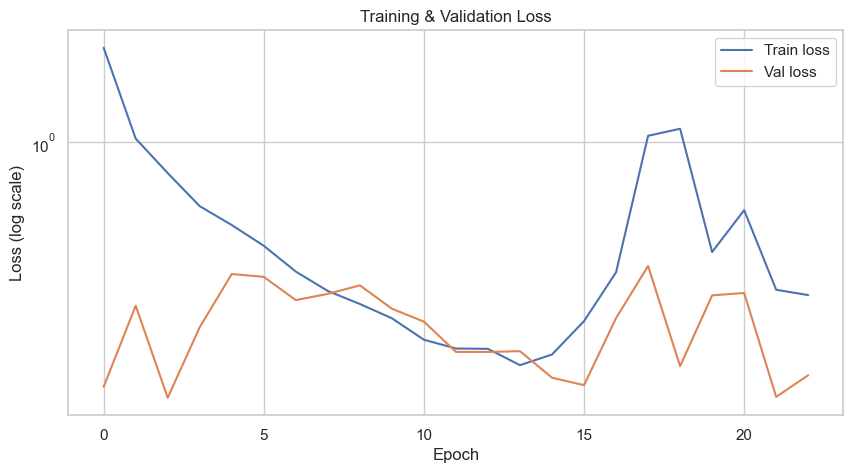

In [17]:
plt.figure(figsize=(10, 5))
plt.semilogy(history.history["loss"], label="Train loss")
plt.semilogy(history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# =======================================================
# 8. Evaluate on test set
# =======================================================
# Predict scaled values
y_pred_test_scaled = final_model.predict(X_test_seq).flatten()
y_test_scaled      = y_test_seq.flatten()

# back to log space
y_pred_log = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()
y_test_log = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# back to original counts (enforces non-negative)
y_pred_test = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test_log)

# Align test dates
test_dates = test_df.index[best_n_input:]

# Metrics
mse  = mean_squared_error(y_test_real, y_pred_test)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_real, y_pred_test)

print("\n📊 LSTM + Transformer (best hyperparams) — Test Performance")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step

📊 LSTM + Transformer (best hyperparams) — Test Performance
MSE  : 220814.232
RMSE : 469.909
MAE  : 152.305


In [19]:
test_months = test_dates.month
for m in range(1, 13):
    mask = (test_months == m)
    if mask.sum() == 0:
        continue
    mae_m = np.mean(np.abs(y_test_real[mask] - y_pred_test[mask]))
    print(f"Month {m:02d} – MAE: {mae_m:.2f}, n={mask.sum()}")


Month 01 – MAE: 5.73, n=10
Month 02 – MAE: 4.28, n=8
Month 03 – MAE: 3.54, n=9
Month 04 – MAE: 1.83, n=10
Month 05 – MAE: 1.20, n=13
Month 06 – MAE: 8.47, n=13
Month 07 – MAE: 45.51, n=14
Month 08 – MAE: 170.50, n=12
Month 09 – MAE: 546.37, n=13
Month 10 – MAE: 595.06, n=14
Month 11 – MAE: 243.51, n=12
Month 12 – MAE: 22.91, n=14


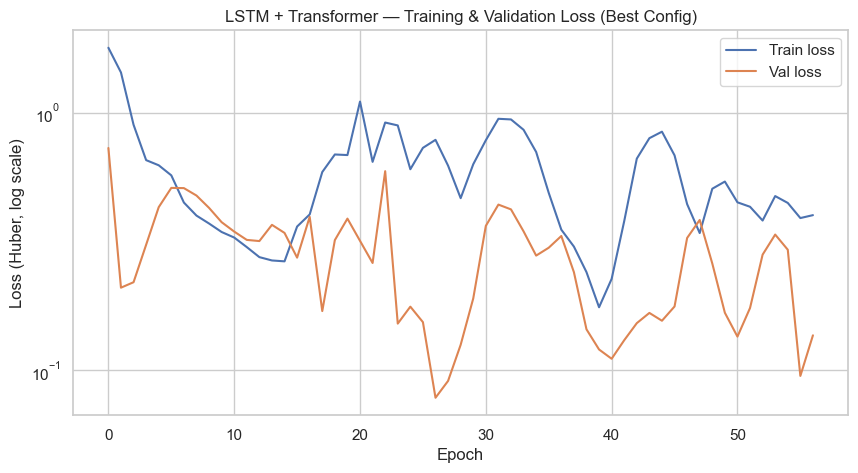

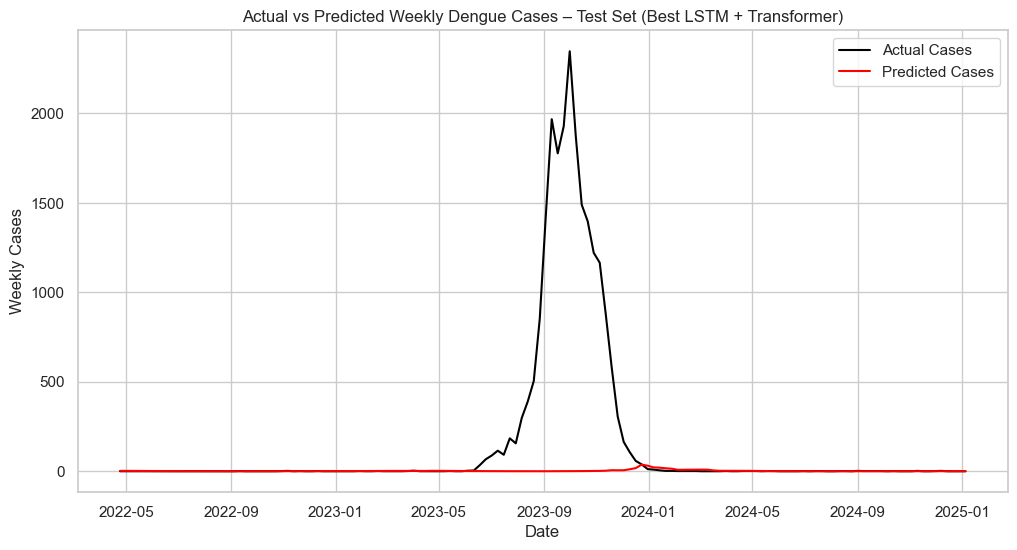

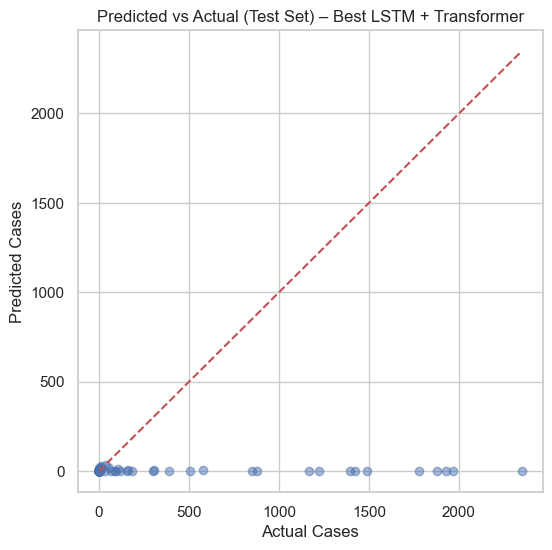

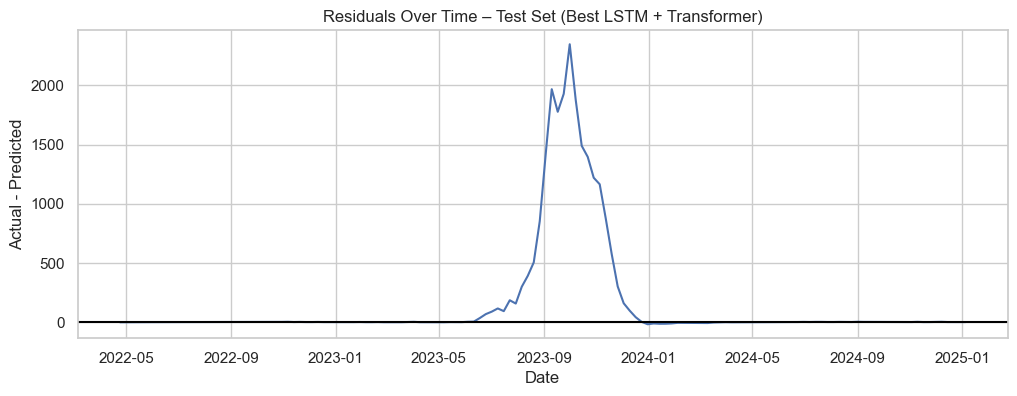

Mean residual (bias): 149.69255848849212


In [20]:
# =======================================================
# 9. Plots
# =======================================================
# Training history
plt.figure(figsize=(10, 5))
plt.semilogy(history_final.history["loss"], label="Train loss")
plt.semilogy(history_final.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (Huber, log scale)")
plt.title("LSTM + Transformer — Training & Validation Loss (Best Config)")
plt.legend()
plt.grid(True)
plt.show()

# Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_real, label="Actual Cases", color="black")
plt.plot(test_dates, y_pred_test, label="Predicted Cases", color="red")
plt.title("Actual vs Predicted Weekly Dengue Cases – Test Set (Best LSTM + Transformer)")
plt.xlabel("Date")
plt.ylabel("Weekly Cases")
plt.legend()
plt.grid(True)
plt.show()

# Scatter: Predicted vs Actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test_real, y_pred_test, alpha=0.5)
max_val = max(y_test_real.max(), y_pred_test.max())
plt.plot([0, max_val], [0, max_val], "r--")
plt.xlabel("Actual Cases")
plt.ylabel("Predicted Cases")
plt.title("Predicted vs Actual (Test Set) – Best LSTM + Transformer")
plt.grid(True)
plt.show()

# Residuals over time
residuals = y_test_real - y_pred_test

plt.figure(figsize=(12, 4))
plt.plot(test_dates, residuals)
plt.axhline(0, color="black")
plt.title("Residuals Over Time – Test Set (Best LSTM + Transformer)")
plt.xlabel("Date")
plt.ylabel("Actual - Predicted")
plt.grid(True)
plt.show()

print("Mean residual (bias):", residuals.mean())


In [21]:
# %% [markdown]
# ## Save artifacts for Streamlit (LSTM + Transformer, Tainan)

# %%
import os, json
from sklearn.metrics import r2_score

# make sure artifacts folder exists
artifacts_dir = "../artifacts"
os.makedirs(artifacts_dir, exist_ok=True)

city_code  = "tn"          # Tainan
model_name = "lstm_att"    # LSTM + attention/transformer

# 1) Test predictions (aligned with test_dates)
pred_df = pd.DataFrame({
    "Date":   test_dates,     # DatetimeIndex from test_df[best_n_input:]
    "y_test": y_test_real,    # true weekly cases
    "y_pred": y_pred_test,    # predicted weekly cases
})
pred_path = f"{artifacts_dir}/{model_name}_{city_code}_predictions.csv"
pred_df.to_csv(pred_path, index=False)
print("✅ Saved predictions to", pred_path)

# 2) Residuals (Actual - Predicted)
resid_df = pd.DataFrame({
    "Date":     test_dates,
    "residual": residuals,    # y_test_real - y_pred_test
})
resid_path = f"{artifacts_dir}/{model_name}_{city_code}_residuals.csv"
resid_df.to_csv(resid_path, index=False)
print("✅ Saved residuals to", resid_path)

# 3) Metrics (add R² for consistency with other models)
r2 = r2_score(y_test_real, y_pred_test)

metrics = {
    "MSE":  float(mse),
    "RMSE": float(rmse),
    "MAE":  float(mae),
    "R2":   float(r2),
}
metrics_path = f"{artifacts_dir}/{model_name}_{city_code}_metrics.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)
print("✅ Saved metrics to", metrics_path)

# 4) Best hyperparameters from the search
best_params = {
    "n_input":    int(best_n_input),
    "num_heads":  int(best_heads),
    "ff_dim":     int(best_ff_dim) if "best_ff_dim" in locals() else int(best_ff_dim),
    "dropout":    float(best_dropout),
    "lr":         float(best_lr),
    "batch_size": int(best_batch_size),
}
best_params_path = f"{artifacts_dir}/{model_name}_{city_code}_best_params.json"
with open(best_params_path, "w") as f:
    json.dump(best_params, f, indent=2)
print("✅ Saved best hyperparameters to", best_params_path)

history_df = pd.DataFrame(history_final.history)
history_df.to_csv(f"../artifacts/{model_name}_{city_code}_history.csv", index=False)


✅ Saved predictions to ../artifacts/lstm_att_tn_predictions.csv
✅ Saved residuals to ../artifacts/lstm_att_tn_residuals.csv
✅ Saved metrics to ../artifacts/lstm_att_tn_metrics.json
✅ Saved best hyperparameters to ../artifacts/lstm_att_tn_best_params.json
